In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History,ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
 #Loading dataset
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')


In [3]:
# Data preprocessing
X = train_data.drop(columns=['label'], axis=1)
y = train_data['label']

In [4]:
# Normalizing the pixel values (between 0 and 1)
X = X / 255.0

# Reshaping X to be 3D - (number of images, 28, 28, 1) for the CNN input
X = X.values.reshape(-1, 28, 28, 1)

# Converting labels to one-hot encoded vectors
y = to_categorical(y, num_classes=10)

In [5]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing cross-validation results
fold_accuracies = []

# Iterate over each fold
for train_index, val_index in kf.split(X):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

In [6]:
    # Build the CNN model
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))  # Input layer with the correct shape
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

In [7]:
 model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint to save best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model_fold.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate, early_stopping, reduce_lr]
                               

# Train the model
history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, 
                    validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, reduce_lr])

# Load the best model and evaluate on the validation set
model.load_weights('best_model_fold.keras')
scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
print(f"Fold Validation Accuracy: {scores[1] * 100:.2f}%")

# Save validation accuracy for this fold
fold_accuracies.append(scores[1])

# After all folds, calculate the mean and std of validation accuracy
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"Mean Validation Accuracy across folds: {mean_accuracy * 100:.2f}%")
print(f"Standard Deviation of Validation Accuracy across folds: {std_accuracy * 100:.2f}%")


Epoch 1/50


I0000 00:00:1726746800.671016      66 service.cc:145] XLA service 0x7ee2a8005e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726746800.671076      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 51/525 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5157 - loss: 1.4311

I0000 00:00:1726746805.081194      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8244 - loss: 0.5491 - val_accuracy: 0.9805 - val_loss: 0.0671 - learning_rate: 0.0010
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9700 - loss: 0.1017 - val_accuracy: 0.9832 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9772 - loss: 0.0732 - val_accuracy: 0.9860 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9826 - loss: 0.0583 - val_accuracy: 0.9886 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 5/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9857 - loss: 0.0465 - val_accuracy: 0.9880 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 6/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9874 - loss: 0.0393 - val_accuracy: 0.9880 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 7/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9888 - loss: 0.0342 - val_accurac

In [8]:
# After K-fold validation, make predictions on test data
X_test = test_data / 255.0
X_test = X_test.values.reshape(-1, 28, 28, 1)

model.load_weights('best_model_fold.keras')  # Load the best model from one of the folds
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare the submission dataframe
digit_recognizer_submission = pd.DataFrame({'ImageId': np.arange(1, len(predicted_labels) + 1),
                                            'Label': predicted_labels})
digit_recognizer_submission.to_csv('digit_recognizer_CNN_K-Fold.csv', index=False)
digit_recognizer_submission.head()

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


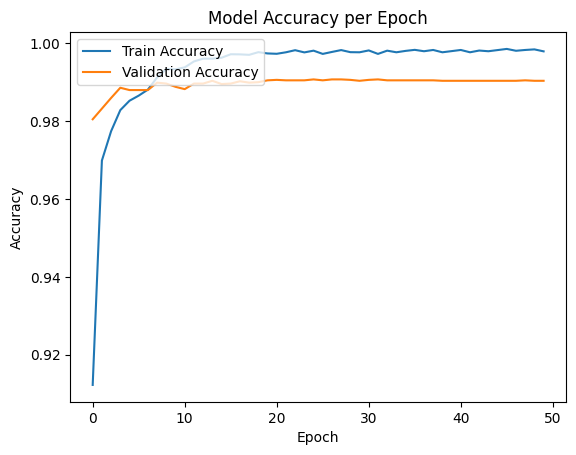

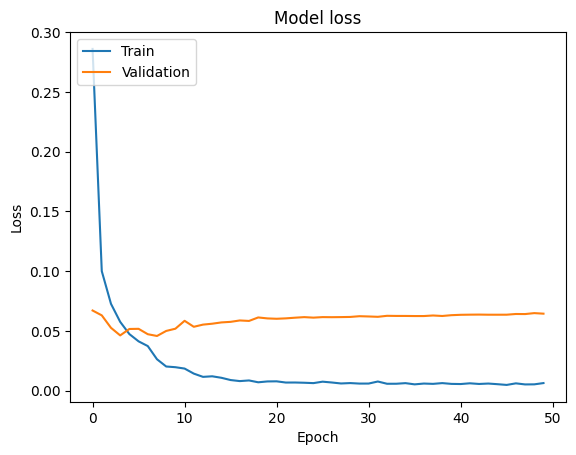

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()